In [9]:
import bayesflow as bf
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import torch
from torch.distributions import Normal, Independent,InverseGamma

import rpy2.robjects as robjects
import numpy as np

In [5]:
def generate_icar_data(tau_range=(4, 400), intercept=0, k=10, s=10, l=10):
    """
    使用 R 的 samples.iCAR 函数生成模拟疾病分布数据，并将其转换为 Python 格式。
    
    参数:
        r_script (str): R 脚本文件路径（默认: "Functions.R"）
        r_data (str): R 数据文件路径（默认: "SpainPROV_CerebrovascularDiseases.Rdata"）
        tau_range (tuple): 精度参数 tau 的范围 (默认: (4, 400))
        intercept (float): 模型的截距 (默认: 0)
        k (int): tau 值的数量 (默认: 10)
        s (int): 随机效应向量的数量 (默认: 10)
        l (int): 每个随机效应生成观测病例的次数 (默认: 10)
        
    返回:
        obs_python (dict): 包含不同 tau 值下生成的观测数据
    """
    # 清空 R 环境
    robjects.r('rm(list = ls())')

    # 加载 R 脚本和数据
    robjects.r('source("Functions.R")')
    robjects.r('load("SpainPROV_CerebrovascularDiseases.Rdata")')


    # 调用 R 的 samples.iCAR 函数生成数据
    robjects.r(f'Obs <- samples.iCAR(Data, tau.range=c({tau_range[0]},{tau_range[1]}), '
               f'intercept={intercept}, k={k}, s={s}, l={l})')

    # 转换 R 数据为 Python 格式
    obs = robjects.r('Obs')
    obs_python = {}

    for i in range(len(obs)):
        matrices = obs[i]  # 获取每个 tau 值的数据
        tau_matrices = [np.array(mat) for mat in matrices]  # 转换为 NumPy 格式
        obs_python[i] = tau_matrices
    
    return obs_python


In [8]:
import tensorflow as tf
import tensorflow_probability as tfp
import bayesflow as bf
import numpy as np

from tensorflow.keras.losses import MeanSquaredError

# 定义 MSE 损失函数
def mse_loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def summary_loss_fn(inputs):
    # 假设 inputs 的最后一维是 sum_out 和 z 的拼接
    # 需要根据实际情况调整 num_or_size_splits 和 axis
    sum_out, z = tf.split(inputs, num_or_size_splits=2, axis=-1)
    return mse_loss_fn(z, sum_out)

# ----------------------
# 定义先验分布 (Prior)
# ----------------------
def prior_fun(batch_size=1):
    """
    定义 intercept (\eta) 的先验分布:
    - intercept (\eta): Uniform(low, high)
    """
    low, high = -2.0, 2.0  # 设定 intercept 的范围
    intercept_dist = tfp.distributions.Uniform(low=low, high=high)
    intercept_samples = intercept_dist.sample(batch_size)
    
    # 返回形状为 (batch_size, 1) 的先验样本
    return tf.expand_dims(intercept_samples, axis=-1)

# ----------------------
# 定义模拟器 (Simulator)
# ----------------------
def likelihood_fun(params, n_obs=10):
    """
    模拟器 (生成观测数据):
    - 使用 R 代码生成疾病映射观测数据 (O_k 和 e)
    """
    intercept = params[:, 0]  # 提取 intercept 参数
    tau = 4  # 固定的 tau 值
    
    # 存储生成的数据 (O_k 和 e)
    inputs = []
    outputs = []

    for eta in intercept:
        # 调用 generate_icar_data() 生成观测数据
        data = generate_icar_data(
            tau_range=(tau, tau),  # 固定 tau
            intercept=eta,        # 当前 intercept
            k=1, s=10, l=n_obs    # 生成 n_obs 次观测
        )
        # 从生成的数据中提取 O_k 和 e
        observed_cases = data[0][0]  # 第一个 tau 值的观测病例数
        expected_cases = robjects.r('Data$E')  # 从 R 数据中提取 e
        expected_cases = np.array(expected_cases)  # 转为 NumPy 格式

        # 存储输入和输出
        inputs.append(np.hstack([observed_cases, expected_cases.reshape(-1, 1)]))  # 合并 O_k 和 e
        outputs.append(eta)  # 记录真实的 intercept (eta)
    
    # 返回输入 (O_k 和 e) 和输出 (eta)
    return np.array(inputs)

# ----------------------
# 定义生成模型 (Generative Model)
# ----------------------
prior = bf.simulation.Prior(prior_fun=prior_fun)
simulator = bf.simulation.Simulator(simulator_fun=likelihood_fun)
model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator)

# ----------------------
# 定义总结网络 (Summary Network)
# ----------------------
summary_net = bf.networks.DeepSet(summary_dim=10)

# ----------------------
# 定义推断网络 (Inference Network)
# ----------------------
inference_net = bf.networks.InvertibleNetwork(
    num_params=1,          # 只推断 1 个参数 intercept
    num_coupling_layers=4  # 网络的耦合层数量
)

# ----------------------
# 定义后验推断器 (Posterior Amortizer)
# ----------------------
# 修改的 MSE 损失函数 Lambda 表达式
amortizer = bf.amortizers.AmortizedPosterior(
    inference_net,
    summary_net,
    summary_loss_fun=summary_loss_fn  # 使用定义好的函数
)


# ----------------------
# 定义 Trainer (训练器)
# ----------------------
trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=model)


# ----------------------
# 开始训练
# ----------------------
trainer.train_online(
    epochs=1,
    iterations_per_epoch=500,
    batch_size=64,
    validation_sims=200,
    early_stopping=True
)

print("训练完成！")


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

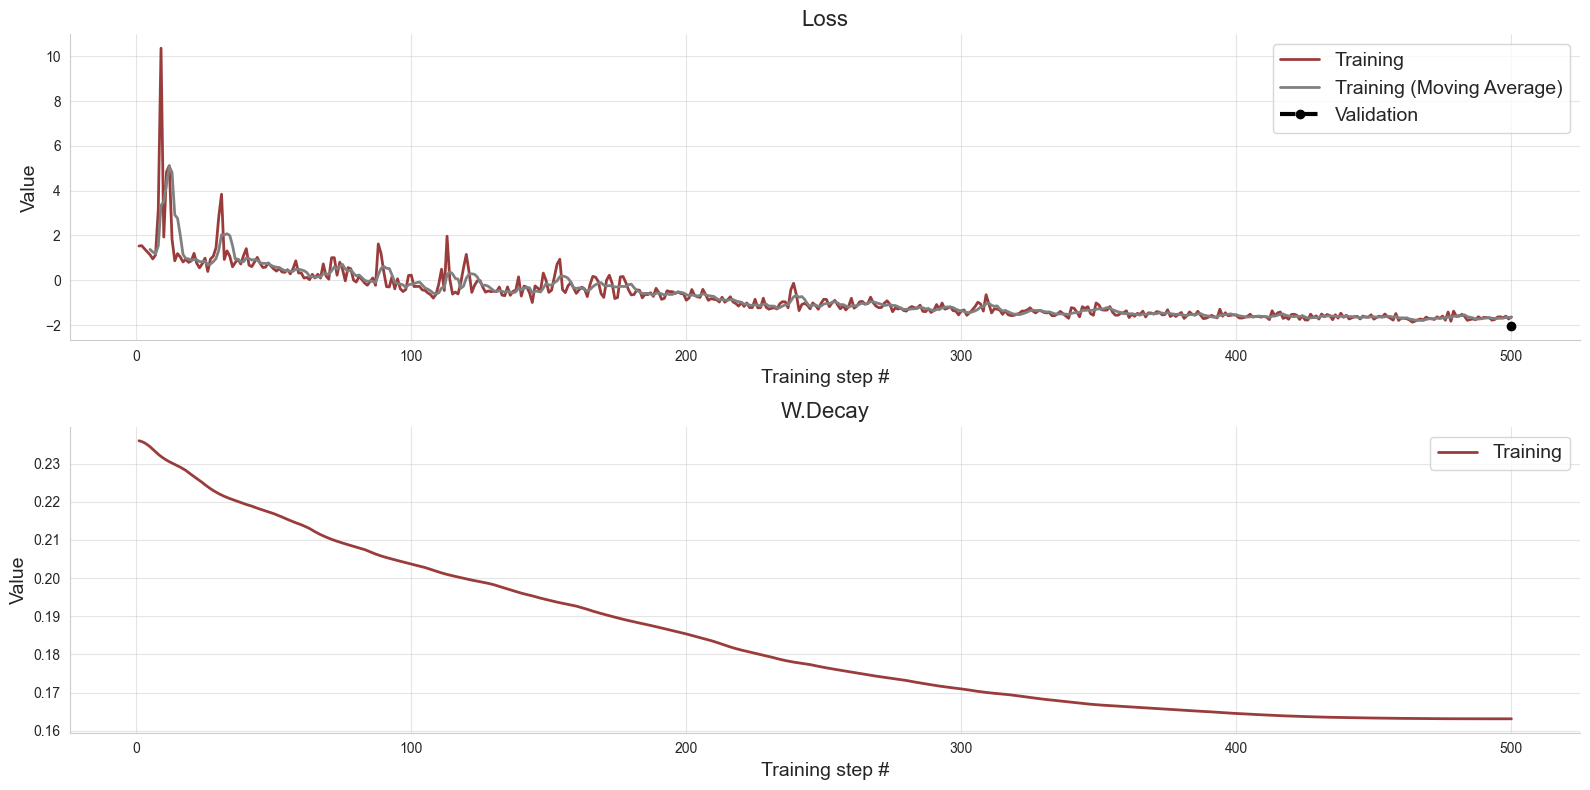

In [55]:
# 可视化训练和验证损失
f = bf.diagnostics.plot_losses(
    history["train_losses"], 
    history["val_losses"], 
    moving_average=True
)

In [77]:
# 生成测试观测数据
test_data = generate_icar_data(
    tau_range=(4, 4),  # 固定 tau
    intercept=0.5,  # 真实的 intercept
    k=1, s=10, l=10  # 生成 10 组观测数据
)

# 提取 O_k 并合并 e
observed_cases = test_data[0][0]  # 观测病例数
expected_cases = robjects.r('Data$E')  # 期望病例数
expected_cases = np.array(expected_cases)

# 组合为输入，确保是二维矩阵
test_input = np.hstack([observed_cases, expected_cases.reshape(-1, 1)])

# 确保 test_input 是二维数组 (batch_size, feature_dim)
test_input = test_input.reshape(1, -1)  # reshape 为 (1, feature_dim)，batch_size=1

# 进行推断
posterior_samples = amortizer.sample({"summary_conditions": test_input}, n_samples=10)

# 打印后验分布样本
print("Posterior samples for log(r_i):", posterior_samples)


tau: 4 


ValueError: Exception encountered when calling layer 'sequential_399' (type Sequential).

Input 0 of layer "dense_1047" is incompatible with the layer: expected axis -1 of input shape to have value 11, but received input with shape (1, 517)

Call arguments received by layer 'sequential_399' (type Sequential):
  • inputs=tf.Tensor(shape=(1, 517), dtype=float32)
  • training=False
  • mask=None

In [59]:
test_input

array([[2.57000000e+02, 7.01000000e+02, 1.59000000e+02, 1.31000000e+02,
        1.08000000e+02, 9.20000000e+01, 7.61000000e+02, 1.09000000e+02,
        3.65000000e+02, 2.40000000e+01, 8.40766907e+01],
       [3.78000000e+02, 8.80000000e+01, 2.54000000e+02, 3.73000000e+02,
        5.44000000e+02, 1.61000000e+02, 5.20000000e+01, 3.00000000e+02,
        1.37000000e+02, 2.29000000e+02, 9.68188847e+01],
       [1.83300000e+03, 2.02000000e+02, 5.01000000e+02, 6.56000000e+02,
        3.54900000e+03, 5.68000000e+02, 3.20000000e+01, 3.32000000e+02,
        2.02200000e+03, 1.02800000e+03, 4.31645889e+02],
       [4.02000000e+02, 3.00000000e+01, 1.07000000e+03, 1.68200000e+03,
        1.31100000e+03, 1.56000000e+02, 1.20000000e+01, 4.00000000e+02,
        2.57000000e+02, 1.40000000e+01, 1.26876728e+02],
       [1.32000000e+02, 9.20000000e+01, 2.12000000e+02, 6.10000000e+01,
        9.60000000e+01, 2.90000000e+01, 8.10000000e+01, 6.70000000e+01,
        1.23000000e+02, 2.02000000e+02, 5.71171319e+

In [65]:
test_data = generate_icar_data(
    tau_range=(4, 4),  # 固定 tau
    intercept=0.5,     # 真实的 intercept
    k=1, s=10, l=10    # 生成 10 组观测数据
)

# 提取 O_k 并合并 e
observed_cases = test_data[0][0]  # 观测病例数
expected_cases = robjects.r('Data$E')  # 从 R 数据中提取 e
expected_cases = np.array(expected_cases)

# 将 O_k 和 e 合并为输入，确保是二维矩阵
combined_new = np.hstack([observed_cases, expected_cases.reshape(-1, 1)])

obs_data_new = combined_new[np.newaxis, :, :]  # 形状 (1, n_obs_new, 2)
obs_data_new = obs_data_new.astype(np.float32) 

summary_vector_new = summary_net(obs_data_new).numpy()
print("Summary vector shape: ", summary_vector_new.shape) 

tau: 4 
Summary vector shape:  (1, 10)


In [69]:
posterior_samples_new = amortizer.sample({"summary_conditions": obs_data_new}, n_samples=100)


In [70]:
posterior_samples_new 


array([[0.44530237],
       [0.41332954],
       [0.4853509 ],
       [0.49725276],
       [0.5851821 ],
       [0.5327341 ],
       [0.5570503 ],
       [0.38838395],
       [0.5625879 ],
       [0.41916662],
       [0.39284176],
       [0.5375691 ],
       [0.5070798 ],
       [0.4237509 ],
       [0.48437554],
       [0.5116351 ],
       [0.4178741 ],
       [0.5028448 ],
       [0.41580355],
       [0.380163  ],
       [0.44510743],
       [0.4957319 ],
       [0.42005795],
       [0.503815  ],
       [0.43800992],
       [0.49430725],
       [0.5906581 ],
       [0.4260059 ],
       [0.48931238],
       [0.52025515],
       [0.49104723],
       [0.5959065 ],
       [0.5552704 ],
       [0.5414448 ],
       [0.52386504],
       [0.42606834],
       [0.44095808],
       [0.4271854 ],
       [0.4300754 ],
       [0.50412464],
       [0.57594997],
       [0.45562315],
       [0.43543062],
       [0.605599  ],
       [0.46628645],
       [0.42516226],
       [0.41050443],
       [0.442

In [75]:

mean_posterior = np.mean(posterior_samples_new )
std_posterior = np.std(posterior_samples_new )
print(f"Average: {mean_posterior:.4f}")
print(f"Standard variance: {std_posterior:.4f}")

Average: 0.4818
Standard variance: 0.0620


/opt/anaconda3/envs/bayesflow/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/bayesflow/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/bayesflow/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/bayesflow/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/bayesflow/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK 

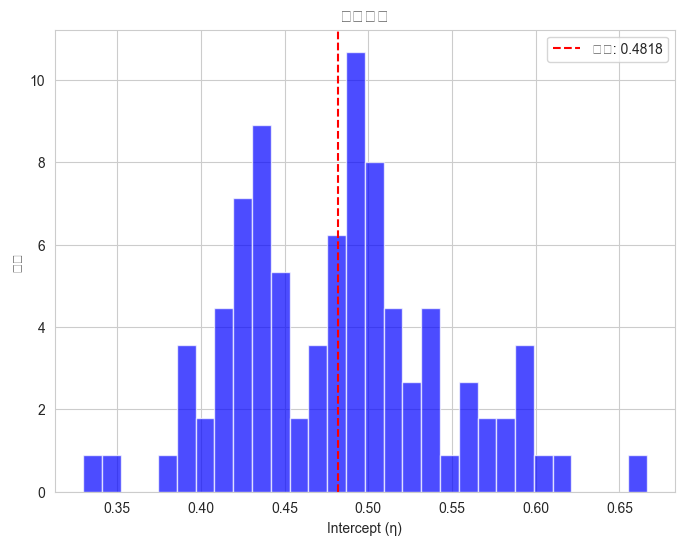

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(posterior_samples_new, bins=30, density=True, alpha=0.7, color='blue')
plt.axvline(x=mean_posterior, color='red', linestyle='--', label=f'均值: {mean_posterior:.4f}')
plt.title('后验分布')
plt.xlabel('Intercept (\u03B7)')
plt.ylabel('密度')
plt.legend()
plt.show()


tau: 4 
Average: 0.9768
Standard variance: 0.0584


/opt/anaconda3/envs/bayesflow/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/bayesflow/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/bayesflow/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/bayesflow/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/bayesflow/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK 

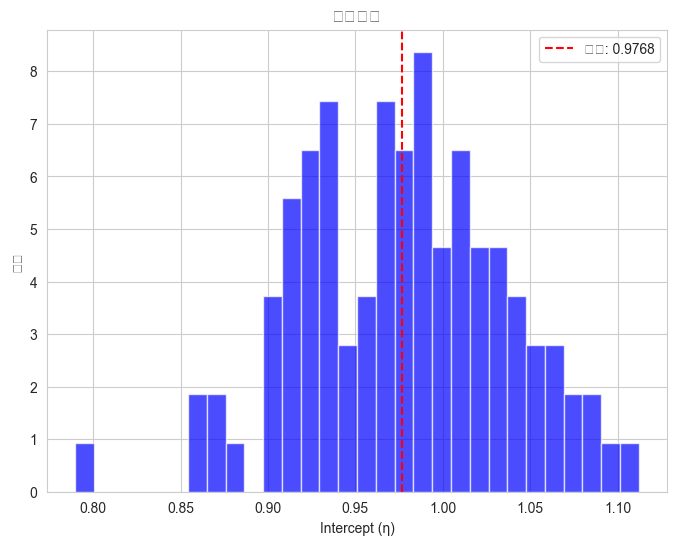

In [79]:
test_data = generate_icar_data(
    tau_range=(4, 4),  # 固定 tau
    intercept=1,     # 真实的 intercept
    k=1, s=10, l=10    # 生成 10 组观测数据
)

# 提取 O_k 并合并 e
observed_cases = test_data[0][0]  # 观测病例数
expected_cases = robjects.r('Data$E')  # 从 R 数据中提取 e
expected_cases = np.array(expected_cases)

# 将 O_k 和 e 合并为输入，确保是二维矩阵
combined_new = np.hstack([observed_cases, expected_cases.reshape(-1, 1)])

obs_data_new = combined_new[np.newaxis, :, :]  # 形状 (1, n_obs_new, 2)
obs_data_new = obs_data_new.astype(np.float32) 

summary_vector_new = summary_net(obs_data_new).numpy()

posterior_samples_new = amortizer.sample({"summary_conditions": obs_data_new}, n_samples=100)


mean_posterior = np.mean(posterior_samples_new )
std_posterior = np.std(posterior_samples_new )
print(f"Average: {mean_posterior:.4f}")
print(f"Standard variance: {std_posterior:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(posterior_samples_new, bins=30, density=True, alpha=0.7, color='blue')
plt.axvline(x=mean_posterior, color='red', linestyle='--', label=f'均值: {mean_posterior:.4f}')
plt.title('后验分布')
plt.xlabel('Intercept (\u03B7)')
plt.ylabel('密度')
plt.legend()
plt.show()


In [80]:
test_data

{0: [array([[  419,  1166,   263,   222,   189,   151,  1250,   168,   609,
             40],
         [  626,   146,   420,   615,   936,   266,    79,   485,   203,
            354],
         [ 3015,   331,   829,  1074,  5666,   868,    62,   517,  3112,
           1691],
         [  663,    49,  1773,  2809,  2099,   261,    13,   630,   413,
             18],
         [  214,   145,   347,    95,   153,    54,   130,   115,   191,
            330],
         [  358,   318,    90,   522,   471,   316,   368,   873,   303,
           2141],
         [ 1725,  1460,   216,  1493, 22195, 27547,  6007,  7092,  7187,
           4905],
         [  474,   913,   616,   183,   228,    92,   731,   462,   236,
            240],
         [ 1384,   168,   304,  1360,   106,    31,   889,    51,   733,
           1527],
         [  405,   123,   276,   779,   972,  1036,   863,  3737,  1363,
           2959],
         [ 1091,  1259,   428,   589,   839,  4669,   665,   353,  1230,
            23